https://www.kaggle.com/bulentsiyah/for-simple-exercises-time-series-forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import datetime

# Data Overview

In [16]:
dataframe = pd.read_csv('data/Alcohol_Sales.csv')
dataframe.DATE = pd.to_datetime(dataframe.DATE)

In [31]:
dataframe = dataframe.sort_values(by='DATE')

In [126]:
dataframe

,DATE,S4248SM144NCEN
0,1992-01-01,3459
1,1992-02-01,3458
2,1992-03-01,4002
3,1992-04-01,4564
4,1992-05-01,4221
...,...,...
320,2018-09-01,12396
321,2018-10-01,13914
322,2018-11-01,14174
323,2018-12-01,15504


# Processing Data

In [52]:
def split_sequence(sequence, n_steps=3):
    sequence = list(sequence)
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    def reshape(d):
        d = np.array(d)
        d = np.reshape(d,(d.shape[0],d.shape[1],1))
        return d
    return reshape(X), np.array(y)

In [142]:
train_data = dataframe['S4248SM144NCEN'].iloc[:200]
test_data = dataframe['S4248SM144NCEN'].iloc[200:]

In [143]:
x_train,y_train = split_sequence(train_data)
x_test,y_test = split_sequence(test_data)

# RNN Model

In [159]:
model = keras.Sequential([
    keras.layers.LSTM(32,input_shape=(3,1,),activation='relu',return_sequences=True),
    keras.layers.LSTM(32,activation='relu'),
    keras.layers.Dense(1)
])

In [205]:
model.compile(loss='mse',optimizer=keras.optimizers.Adam(learning_rate=0.0001))

In [206]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 3, 32)             4352      
_________________________________________________________________
lstm_33 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


# Callback & Earlystoping

In [62]:
%load_ext tensorboard

In [61]:
os.makedirs('logs',exist_ok=True)

In [63]:
logdir = os.path.join('logs',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [64]:
callback = keras.callbacks.TensorBoard(logdir)
earlyStoping = keras.callbacks.EarlyStopping(monitor='loss',patience=3)

# Training Model

In [207]:
history = model.fit(x_train,y_train,epochs=10,callbacks=[callback,earlyStoping],verbose=2)

Train on 197 samples
Epoch 1/10
197/197 - 2s - loss: 782479.3974
Epoch 2/10
197/197 - 0s - loss: 776677.4381
Epoch 3/10
197/197 - 0s - loss: 775144.9473
Epoch 4/10
197/197 - 0s - loss: 773888.4791
Epoch 5/10
197/197 - 0s - loss: 775531.9004
Epoch 6/10
197/197 - 0s - loss: 775146.0159
Epoch 7/10
197/197 - 0s - loss: 775654.3401


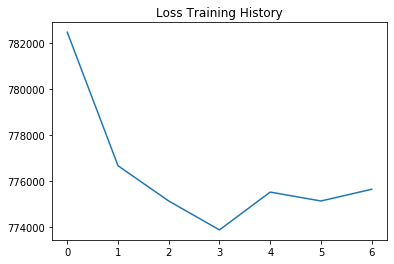

In [208]:
plt.plot(history.history['loss'])
plt.title('Loss Training History');

# Demonstrate Prediction

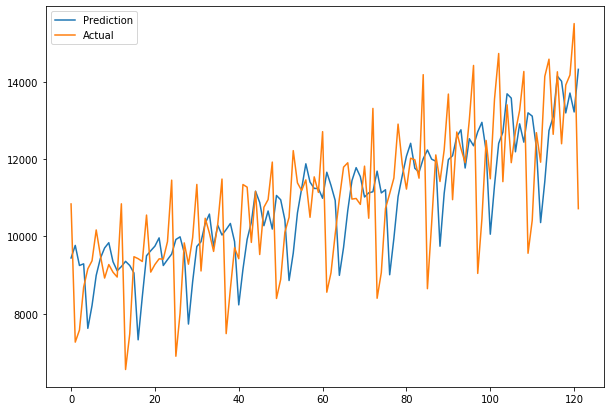

In [209]:
plt.figure(figsize=(10,7))
plt.plot(model.predict(x_test),label='Prediction')
plt.plot(y_test,label='Actual')
plt.legend()

# Future Prediction

In [210]:
def predict_future(shift_count):
    def reshape(three):
        return np.array(three).reshape(1,3,1) 
    array =  list(dataframe['S4248SM144NCEN']) + []
    now = len(dataframe)-3
    last = len(dataframe)
    for _ in range(shift_count):
        converted = reshape(array[now:last])
        array.append(model.predict(converted)[0][0])
        now += 1
        last += 1
    return array

In [211]:
future_prediction = predict_future(200)

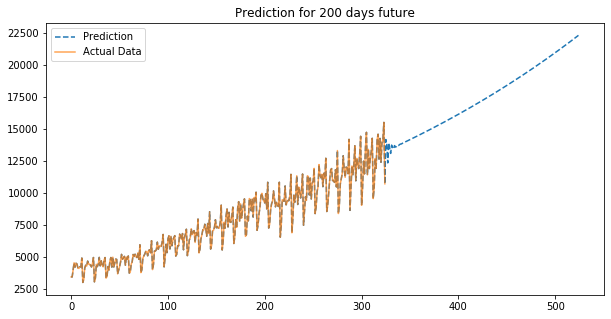

In [212]:
plt.figure(figsize=(10,5))
plt.plot(future_prediction,'--',label='Prediction')
plt.plot(dataframe['S4248SM144NCEN'],label='Actual Data',alpha=0.7)
plt.title('Prediction for 200 days future')
plt.legend();

# Save Model

In [213]:
model.save('models/AlcoholSales.h5')